I build classification models to detect spam messages, based on the email characteristic.

In the project, there are two scenarios:
1. The best model in terms of the overall predictive accuracy.
2. The best model in terms of the cost sensitive condition.

One model has best accuracy, while the other is a cost sensitive model to minimize misclassification cost. 

I built the models using five techniques, decision tree, logistic regression, k-nearest neighbors, support vector machine and LightGBM. I first used nested grid search cv to find the best model, then conducted hyper-parameter tuning to find the best outcome of the model. 

# Import packages and files

In [44]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, make_scorer
from sklearn import tree
from sklearn import linear_model
from sklearn import neighbors, datasets
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
import scikitplot as skplt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Import data

names= ['wf_make','wf_address','wf_all','wf_3d','wf_our','wf_over','wf_remove','wf_internet','wf_order','wf_mail',
              'wf_receive','wf_will','wf_people','wf_report','wf_addresses','wf_free','wf_business','wf_email','wf_you',
              'wf_credit','wf_your','wf_font','wf_000','wf_money','wf_hp','wf_hpl','wf_george','wf_650','wf_lab','wf_labs',
             'wf_telnet','wf_857','wf_data','wf_415','wf_85','wf_technology','wf_1999','wf_parts','wf_pm','wf_direct',
              'wf_cs','wf_meeting','wf_original','wf_project','wf_re','wf_edu','wf_table','wf_conference','wf_;','wf_(',
             'wf_[','wf_!','wf_$','wf_#','crl_average','crl_longest','crl_total','prediction']
df = pd.read_csv('spambase.data', names=names)

In [4]:
df.head()

,wf_make,wf_address,wf_all,wf_3d,wf_our,wf_over,wf_remove,wf_internet,wf_order,wf_mail,...,wf_;,wf_(,wf_[,wf_!,wf_$,wf_#,crl_average,crl_longest,crl_total,prediction
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [5]:
df['prediction'] = df['prediction'].astype('category')

In [6]:
#Shape of dataframe
n_row, n_features = df.shape
print ('The dimensions of the data set are', n_row, 'by', (n_features-1))

The dimensions of the data set are 4601 by 57


In [7]:
#How much different are the target variable
print ("Total number of spams are", str(df.shape[0]), ",", df['prediction'].value_counts()[1], "spam and",df['prediction'].value_counts()[0], "non-spam"
)

Total number of spams are 4601 , 1813 spam and 2788 non-spam


In [8]:
# Check for missing data
cols_with_missing = [col for col in df.columns if df[col].isnull().any()]
miss_count = df.isna().sum()
miss_count.div(len(df))[cols_with_missing]

Series([], dtype: float64)

# Data pre-processing

In [9]:
X = df.drop(labels=['prediction'],axis=1)
Y = df['prediction']

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Model Selection

In [11]:
#create a dictionary to save the result
accuracy_scores = {'tree':{},'knn':{},'logistic':{},'svm':{},'LGBM':{}}

In [12]:
#Define inner and outer cross validation
inner_cv=KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv=KFold(n_splits=5, shuffle=True, random_state=42)

In [13]:
#Decision Tree
tree_grid = {'max_depth':list(range(2,10)), 'criterion': ["entropy", "gini"], 'min_samples_split':list(range(2,10))}

tree = tree.DecisionTreeClassifier(random_state=42)
tree_clf=GridSearchCV(estimator=tree, param_grid=tree_grid, cv = inner_cv, scoring = 'accuracy')

#Nested CV with parameter opitimization
tree_score=cross_val_score(tree_clf,X=X,y=Y, cv=outer_cv)
accuracy_scores['tree']=tree_score.mean()

In [14]:
#Logistic Regression

log_grid = {'C': [0.1, 10,100, 1000], 'solver' :["liblinear", "newton-cg"], 'penalty':['l1', 'l2', 'elasticnet']}

log =  linear_model.LogisticRegression(multi_class='multinomial',random_state=42)
log_clf=GridSearchCV(estimator=log, param_grid=log_grid, cv = inner_cv, scoring = 'accuracy')

#Nested CV with parameter opitimization
log_score=cross_val_score(log_clf,X=X,y=Y, cv=outer_cv)
accuracy_scores['logistic']=log_score.mean()

In [15]:
#KNN
knn_grid = {'n_neighbors': list(range(1,10)), 'weights': ["uniform", "distance"]}

knn = neighbors.KNeighborsClassifier()
knn_clf=GridSearchCV(estimator=knn, param_grid=knn_grid, cv = inner_cv, scoring = 'accuracy')

#Nested CV with parameter opitimization
knn_score=cross_val_score(knn_clf,X=X,y=Y, cv=outer_cv)
accuracy_scores['knn']=knn_score.mean()

In [24]:
#SVM
svm_grid = {'kernel' :['rbf'],'C':[1,10,100]}

svm= SVC(random_state = 45,probability = True)
svm_clf=GridSearchCV(estimator=svm, param_grid=svm_grid, cv = inner_cv, scoring = 'accuracy')

#Nested CV with parameter opitimization
svm_score=cross_val_score(svm_clf,X=X,y=Y, cv=outer_cv)
accuracy_scores['svm']=svm_score.mean()


In [28]:
#LightGBM
lgbm_grid = {'max_depth':[-1],'num_leaves':[22, 31],'learning_rate':[0.05,0.1,0.3]}

lgbm = LGBMClassifier()
lgbm_clf=GridSearchCV(estimator=lgbm, param_grid=lgbm_grid, cv = inner_cv, scoring = 'accuracy')

#Nested CV with parameter opitimization
lgbm_score=cross_val_score(lgbm_clf,X=X.values,y=Y, cv=outer_cv)
accuracy_scores['LGBM']=lgbm_score.mean()

In [29]:
accuracy_scores

{'tree': 0.9213218146627012,
 'knn': 0.8230843128924137,
 'logistic': 0.9261056035500165,
 'svm': 0.8359061511589483,
 'LGBM': 0.9582681867535288}

By comparing the accuracy among the five models, decision tree (0.9221),KNN (0.823), logistic regression (0.926), SVM (0.836) and LightGBM (0.958), I found out the best model is LightGBM. Therefore, I split the data into train and test, trained the model with train data, performed hyperparameter tuning for LightGBM, then predicted spam or not with test data.

# Train Test Split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                    test_size=0.2,
                                    random_state=41)

# LightGBM

In [34]:
params = {"learning_rate": [0.05,0.1,0.3] , "num_leaves": [30, 40,50,60,70], "max_depth": [30, 40,50,60,70]}

lgbm = LGBMClassifier()
lgbm_clf=GridSearchCV(estimator=lgbm, param_grid=params, cv = 5, scoring = 'accuracy')

lgbm_clf.fit(X_train.values, y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.3],
                         'max_depth': [30, 40, 50, 60, 70],
                         'num_leaves': [30, 40, 50, 60, 70]},
             scoring='accuracy')

Best cross validation score = 0.957608695652174
Best hyperparameter = {'learning_rate': 0.3, 'max_depth': 30, 'num_leaves': 30}
LGBMClassifier(learning_rate=0.3, max_depth=30, num_leaves=30)
Prediction Accuracy:  0.9652551574375678
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       538
           1       0.95      0.97      0.96       383

    accuracy                           0.97       921
   macro avg       0.96      0.97      0.96       921
weighted avg       0.97      0.97      0.97       921



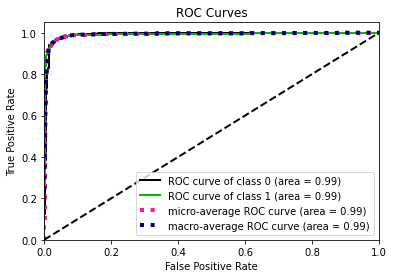

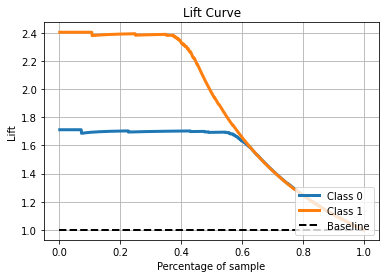

In [38]:
print ("Best cross validation score =",lgbm_clf.best_score_)
print ("Best hyperparameter =",lgbm_clf.best_params_)
print (lgbm_clf.best_estimator_)

#Accuracy
print("Prediction Accuracy: ",accuracy_score(y_test, lgbm_clf.predict(X_test)))

# Classification report
print(classification_report(y_test,lgbm_clf.predict(X_test)))

#ROC
predicted_probas_grid_log = lgbm_clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, predicted_probas_grid_log)

#Lift
skplt.metrics.plot_lift_curve(y_test, predicted_probas_grid_log)
plt.show()

It turned out that the best hyperparameter is when learning_rate= 0.3, max_depth=30 and num_leaves =30. The model accuracy on testing data is 0.965.

In addition, I also drew the ROC curve and lift curve as below. For the ROC curve, classifiers that give curves closer to the top-left corner indicate a better performance. Therefore, the ROC performs well in my model. On the other hand, the lift curve shows that the model performance is better than by chance. For 10% of email, using no model we should get 10% labeled ' not spam' and using the given model we should get around 17% labeled ' not spam'. For 10% of email, using no model we should get 10% labeled 'spam' and using the given model we should get around 24% labeled 'spam'.

# Considering Cost

The cost ratio for different misclassification errors is 10:1, which is the ratio pf false positive: false negative. 

False positive means labeling non-spam mails as spams. The cost of this misclassification is very high and undesirable. 

In [40]:
#I defined a function to calculate cost

def cost_func(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    costs = cm[0][1] * 10 + cm[1][0] * 1
    return costs

cost_metric = make_scorer(cost_func, greater_is_better= False)

In [41]:
cost_scores = {'tree':{},'knn':{},'logistic':{},'svm':{},'LGBM':{}}

In [45]:
#Decision Tree
tree_grid = {'max_depth':list(range(2,10)), 'criterion': ["entropy", "gini"], 'min_samples_split':list(range(2,10))}

tree = tree.DecisionTreeClassifier(random_state=42)
tree_clf=GridSearchCV(estimator=tree, param_grid=tree_grid, cv = inner_cv, scoring = cost_metric)

#Nested CV with parameter opitimization
tree_score=cross_val_score(tree_clf,X=X,y=Y, cv=outer_cv)
cost_scores['tree']=tree_score.mean()

In [47]:
#Logistic Regression

log_grid = {'C': [0.1, 10,100, 1000], 'solver' :["liblinear", "newton-cg"], 'penalty':['l1', 'l2', 'elasticnet']}

log =  linear_model.LogisticRegression(multi_class='multinomial',random_state=42)
log_clf=GridSearchCV(estimator=log, param_grid=log_grid, cv = inner_cv, scoring = cost_metric)

#Nested CV with parameter opitimization
log_score=cross_val_score(log_clf,X=X,y=Y, cv=outer_cv)
cost_scores['logistic']=log_score.mean()

In [48]:
#KNN
knn_grid = {'n_neighbors': list(range(1,10)), 'weights': ["uniform", "distance"]}

knn = neighbors.KNeighborsClassifier()
knn_clf=GridSearchCV(estimator=knn, param_grid=knn_grid, cv = inner_cv, scoring = cost_metric)

#Nested CV with parameter opitimization
knn_score=cross_val_score(knn_clf,X=X,y=Y, cv=outer_cv)
cost_scores['knn']=knn_score.mean()

In [49]:
#SVM
svm_grid = {'kernel' :['rbf'],'C':[1,10,100]}

svm= SVC(random_state = 45,probability = True)
svm_clf=GridSearchCV(estimator=svm, param_grid=svm_grid, cv = inner_cv, scoring = cost_metric)

#Nested CV with parameter opitimization
svm_score=cross_val_score(svm_clf,X=X,y=Y, cv=outer_cv)
cost_scores['svm']=svm_score.mean()


In [50]:
#LightGBM
lgbm_grid = {'max_depth':[-1],'num_leaves':[22, 31],'learning_rate':[0.05,0.1,0.3]}

lgbm = LGBMClassifier()
lgbm_clf=GridSearchCV(estimator=lgbm, param_grid=lgbm_grid, cv = inner_cv, scoring = cost_metric)

#Nested CV with parameter opitimization
lgbm_score=cross_val_score(lgbm_clf,X=X.values,y=Y, cv=outer_cv)
cost_scores['LGBM']=lgbm_score.mean()

In [51]:
cost_scores

{'tree': -351.8,
 'knn': -584.0,
 'logistic': -325.4,
 'svm': -649.6,
 'LGBM': -230.8}

By comparing the cost metric among the five models, decision tree (351.8),KNN (584), logistic regression (325.4), SVM (649.6) and LightGBM (230.8), I found out the best model is LightGBM. Therefore, I split the data into train and test, trained the model with train data, performed hyperparameter tuning for LightGBM, then predicted spam or not with test data.

# LightGBM

In [52]:
params = {"learning_rate": [0.05,0.1,0.3] , "num_leaves": [30, 40,50,60,70], "max_depth": [30, 40,50,60,70]}

lgbm = LGBMClassifier()
lgbm_clf=GridSearchCV(estimator=lgbm, param_grid=params, cv = 5, scoring = cost_metric)

lgbm_clf.fit(X_train.values, y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.3],
                         'max_depth': [30, 40, 50, 60, 70],
                         'num_leaves': [30, 40, 50, 60, 70]},
             scoring=make_scorer(cost_func, greater_is_better=False))

Best cross validation score = -166.6
Best hyperparameter = {'learning_rate': 0.3, 'max_depth': 30, 'num_leaves': 40}
LGBMClassifier(learning_rate=0.3, max_depth=30, num_leaves=40)

The cost for the model is 172
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       538
           1       0.96      0.97      0.96       383

    accuracy                           0.97       921
   macro avg       0.97      0.97      0.97       921
weighted avg       0.97      0.97      0.97       921



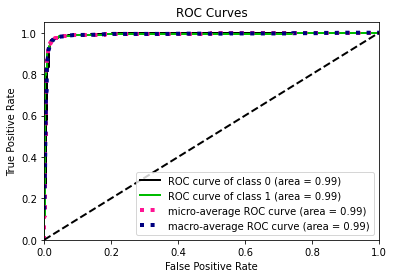

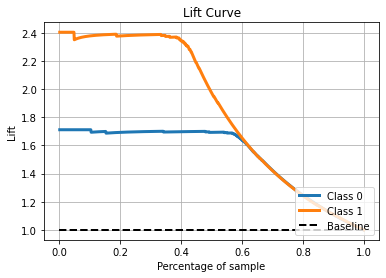

In [57]:
print ("Best cross validation score =",lgbm_clf.best_score_)
print ("Best hyperparameter =",lgbm_clf.best_params_)
print (lgbm_clf.best_estimator_)

#Cost

cm = confusion_matrix(y_test,lgbm_clf.predict(X_test))
cost_gbr = cm[0][1]*10 + cm[1][0]*1
print()
print('The cost for the model is %d' %cost_gbr)

# Classification report
print(classification_report(y_test,lgbm_clf.predict(X_test)))


#ROC
predicted_probas_grid_log = lgbm_clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, predicted_probas_grid_log)

#Lift
skplt.metrics.plot_lift_curve(y_test, predicted_probas_grid_log)
plt.show()

In [67]:
#Misclassification Cost

mis= cost_gbr/(cm.sum())

print('The average misclassification cost for the model is', round(mis,2))

The average misclassification cost for the model is 0.19


It turned out that the best hyperparameter is when learning_rate= 0.3, max_depth=30 and num_leaves =40. The cost metric on testing data is 172.

The average misclassification cost is 0.19.

In addition, I also drew the ROC curve and lift curve as below. For the ROC curve, classifiers that give curves closer to the top-left corner indicate a better performance. Therefore, the ROC performs well in my model. On the other hand, the lift curve shows that the model performance is better than by chance. For 10% of email, using no model we should get 10% labeled ' not spam' and using the given model we should get around 17% labeled ' not spam'. For 10% of email, using no model we should get 10% labeled 'spam' and using the given model we should get around 24% labeled 'spam'.

## Conclusion

In both scenerios on evaluating accuracy and cost-effective, the best model is LightGBM. However, the hyper-parameters of the two models are slightly different since the performance metric are not the same. 